# ![Keras](https://img.shields.io/badge/Keras-%23D00000.svg?style=for-the-badge&logo=Keras&logoColor=white) **INTRODUCTION TO ARTIFICIAL NEURAL NETWORKS WITH KERAS - EXERCISES**

---

## **SETUP:**

In [2]:
# %load ../initial_settings.py
"""
Initial settings for data analysis and machine learning.
Use this with: %load ../initial_settings.py
"""

import os
import sys
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from packaging import version

# This notebook requires Python 3.7 or above and Scikit-Learn 1.0.1 or above.
assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# And TensorFlow 2.8 or above.
assert version.parse(tf.__version__) >= version.parse("2.8.0")

# Graphviz source.
os.environ["PATH"] += os.pathsep + "C:/Programy/Graphviz/bin/"

# Default settings for matplotlib.
DARK_BLUE = "#03002e"
LIGHT_GRAY = "#8f8f99"

plt.rc("font", size=14)
plt.rc("legend", fontsize=14)
plt.rc("text", color=DARK_BLUE)

plt.rc("axes", labelsize=14)
plt.rc("axes", titlesize=14)
plt.rc("axes", labelpad=10)
plt.rc("axes", labelcolor=DARK_BLUE)
plt.rc("axes", grid=True)

plt.rc("xtick", labelsize=12, color=DARK_BLUE)
plt.rc("ytick", labelsize=12, color=DARK_BLUE)
plt.rc("xtick.major", pad=10)
plt.rc("ytick.major", pad=10)

plt.rc("grid", color=LIGHT_GRAY)
plt.rc("grid", linestyle="dashed")
plt.rc("grid", linewidth=0.5)
plt.rc("grid", alpha=0.5)

# Create a directory for matplotlib images.
IMAGES_PATH = Path("images")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)


def save_fig(
    fig_id, tight_layout=True, fig_extension="png", resolution=300, facecolor="w"
):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, facecolor=facecolor)


---

## **EXERCISE 01:**

*Exercise: Train a deep MLP on the MNIST dataset (you can load it using `tf.keras.datasets.mnist.load_data()`. See if you can get over 98% accuracy by manually tuning the hyperparameters. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Next, try tuning the hyperparameters using Keras Tuner with all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.*

Let's load the dataset:

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [4]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is also represented as a byte (0 to 255):

In [5]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [6]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]


Let's plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

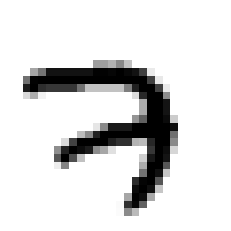

In [8]:
plt.imshow(X_train[0], cmap="binary")
plt.axis("off")
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a `class_names` array:

In [9]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [10]:
X_valid.shape

(5000, 28, 28)

In [11]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

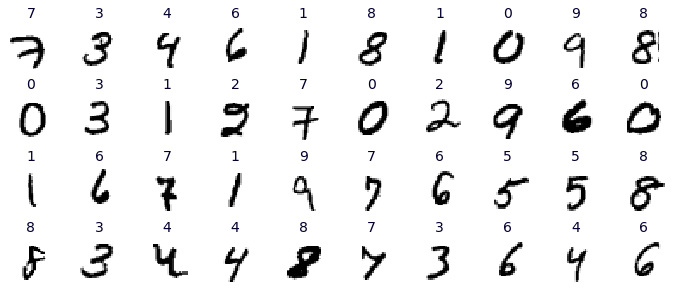

In [12]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [13]:
K = tf.keras.backend


class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(
            self.model.optimizer.learning_rate,
            self.model.optimizer.learning_rate * self.factor,
        )


In [15]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(300, activation="relu"),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)


We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [17]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch:

In [18]:
history = model.fit(
    X_train, y_train, epochs=1, validation_data=(X_valid, y_valid), callbacks=[expon_lr]
)


1719/1719 [==============================] - 10s 5ms/step - loss: nan - accuracy: 0.5786 - val_loss: nan - val_accuracy: 0.0958


Text(0, 0.5, 'Loss')

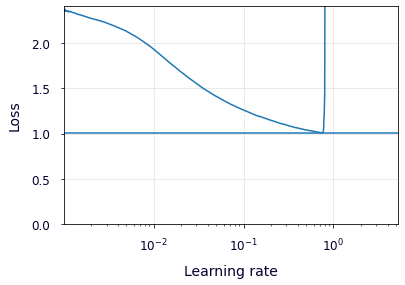

In [21]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale("log")
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")


The loss starts shooting back up violently when the learning rate goes over 6e-1, so let's try using half of that, at 3e-1:

In [22]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [23]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(300, activation="relu"),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)


In [24]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)


In [25]:
run_index = 1  # increment this at every run
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir


WindowsPath('my_mnist_logs/run_001')

In [26]:
early_stooping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_mnist_model", save_best_only=True
)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb, early_stooping_cb, tensorboard_cb],
)


Epoch 1/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2368 - accuracy: 0.9255 - val_loss: 0.1001 - val_accuracy: 0.9696
Epoch 2/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0939 - accuracy: 0.9712 - val_loss: 0.1228 - val_accuracy: 0.9668
Epoch 3/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0666 - accuracy: 0.9783 - val_loss: 0.0764 - val_accuracy: 0.9778
Epoch 4/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0504 - accuracy: 0.9839 - val_loss: 0.0746 - val_accuracy: 0.9804
Epoch 5/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0337 - accuracy: 0.9890 - val_loss: 0.0708 - val_accuracy: 0.9794
Epoch 6/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0291 - accuracy: 0.9905 - val_loss: 0.0703 - val_accuracy: 0.9804
Epoch 7/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0241 - accuracy: 0.9922 - val_loss: 0.0870 - val_ac

In [27]:
model = tf.keras.models.load_model("my_mnist_model")  # Rollback to best model.
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 16.2489 - accuracy: 0.9755


[16.2489070892334, 0.9754999876022339]

In [41]:
%reload_ext tensorboard
%tensorboard --logdir=./my_mnist_logs --host localhost --port 8088

Reusing TensorBoard on port 8088 (pid 6704), started 0:01:17 ago. (Use '!kill 6704' to kill it.)